In [69]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from alibi.explainers import CEM

from tensorflow_model import load_image
import numpy as np
import random

# print('TF version: ', tf.__version__)
# print('Eager execution enabled: ', tf.executing_eagerly()) # False

# Use ImageNetV2 "MatchedFrequency" test set

In [ ]:
# TODO: datset_creater anschauen; true lables are still missing

In [141]:
from torchvision import datasets
data_handler = datasets.ImageFolder(root="C:/Users/julia/OneDrive/Dokumente/GitHub/development/files/imagenetv2-matched-frequency-format-val")

In [157]:
def sample_random_images(data_handler, number, seed=None):
    images = []
    img_paths = data_handler.imgs.copy()
    if seed:
        random.seed(seed)
    for i in range(number):
        rand_idx = random.randint(0, len(img_paths))
        rand_img_path = img_paths.pop(rand_idx)[0]
        rand_img = data_handler.loader(rand_img_path)
        # resize
        rand_img = rand_img.resize((224, 224))
        # convert to np array
        images.append(np.array(rand_img))
    return np.array(images)

In [182]:
x_test = sample_random_images(data_handler, 5, 5)

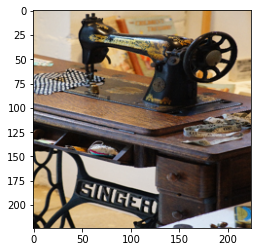

In [183]:
for img in images:
    plt.imshow(img)

# Load pretrained CNN model

In [189]:
cnn = tf.keras.applications.VGG16(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000
)

# Train or load auto-encoder

In [178]:
from autoencoder.autoencoder import Autoencoder

In [181]:
ae = Autoencoder(load_path="files/imagenet_ae.h5")

In [180]:
# ae.fit(data_path="./autoencoder/train_imagenet.npy", epochs=4, use_multiprocessing=True)

In [171]:
# Compare original with decoded images
#ae = load_model('mnist_ae.h5')
decoded_imgs = ae.predict(images)

C:\Users\julia\anaconda3\envs\xai_env\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [176]:
decoded_imgs = decoded_imgs / 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


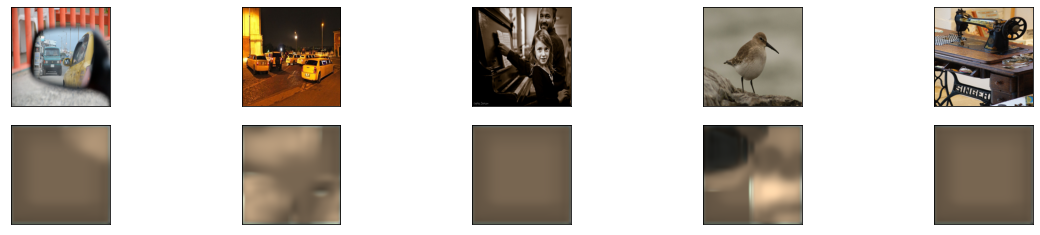

In [206]:
# Compare original with decoded images
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Generate contrastive explanation with pertinent negative

In [236]:
idx = 3
X = x_test[idx].reshape((1,) + x_test[idx].shape)
X = X / 255

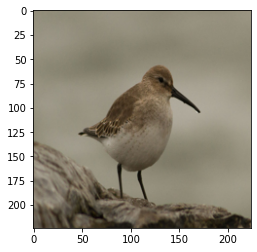

In [237]:
plt.imshow(X[0]);

In [239]:
cnn.predict(X).argmax(), cnn.predict(X).max()

(669, 0.05173149)

In [220]:
# CEM parameters
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_test.shape[1:]  # instance shape
kappa = 0.  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
gamma = 100  # weight of the optional auto-encoder loss term
c_init = 1.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (x_test.min(),x_test.max())  # feature range for the perturbed instance
clip = (-1000., 1000.)  # gradient clipping
lr = 1e-2  # initial learning rate
no_info_val = -1. # a value, float or feature-wise, which can be seen as containing no info to make a prediction
                  # perturbations towards this value means removing features, and away means adding features
                  # for our MNIST images, the background (-0.5) is the least informative,
                  # so positive/negative perturbations imply adding/removing features

In [234]:
X

array([[[[146, 141, 122],
         [145, 140, 121],
         [147, 142, 123],
         ...,
         [154, 149, 130],
         [153, 148, 129],
         [154, 149, 130]],

        [[146, 141, 122],
         [146, 141, 122],
         [145, 140, 122],
         ...,
         [154, 149, 130],
         [154, 149, 130],
         [155, 150, 131]],

        [[146, 141, 122],
         [146, 141, 122],
         [146, 140, 122],
         ...,
         [154, 149, 130],
         [153, 148, 129],
         [156, 151, 132]],

        ...,

        [[ 97,  91,  79],
         [100,  92,  81],
         [100,  93,  81],
         ...,
         [ 40,  36,  25],
         [ 60,  49,  36],
         [ 99,  83,  61]],

        [[ 96,  89,  77],
         [ 99,  91,  80],
         [100,  93,  82],
         ...,
         [ 44,  36,  29],
         [ 55,  43,  35],
         [ 95,  79,  61]],

        [[ 98,  90,  79],
         [100,  91,  80],
         [101,  94,  83],
         ...,
         [ 52,  43,  34],
        

In [221]:
# start 17:29 gehe um 19:04 und Programm läuft noch
# initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

Pertinent negative prediction: 140


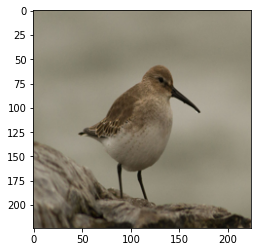

In [226]:
print(f'Pertinent negative prediction: {explanation.PN_pred}')
plt.imshow(explanation.PN[0]/255);

In [231]:
cnn.predict(explanation.PN / 255).argmax(), cnn.predict(explanation.PN /255).max()

(669, 0.051648863)

# Generate pertinent positive

In [38]:
mode = 'PP'

In [39]:
# initialize CEM explainer and explain instance
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

Pertinent positive prediction: 5


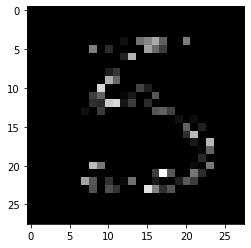

In [40]:
print(f'Pertinent positive prediction: {explanation.PP_pred}')
plt.imshow(explanation.PP.reshape(28, 28));